In [ ]:
import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration
from pathlib import Path

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_ID = "llava-hf/llava-onevision-qwen2-7b-ov-hf"

processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
model     = LlavaOnevisionForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype       = torch.bfloat16,
    device_map        = "auto",
    low_cpu_mem_usage = True,
    trust_remote_code = True,
).eval().to(device)

# # LLaVA Answer & Attention Ranking

In [ ]:
pairs = torch.load(
    "/home/s2behappy4/data/gyuhyeong/code/siglip/hazelnut/crack/"
    "hazelnut_001_token_mask_pairs.pt"
)
mask_tokens = torch.stack([p["mask_token"] for p in pairs])      

mask_tokens = mask_tokens.to(device, dtype=model.dtype).unsqueeze(0) 

with torch.no_grad():
    mask_embeds = model.multi_modal_projector(mask_tokens)          

mask_attn = torch.ones(1, mask_embeds.size(1), dtype=torch.long, device=device)

prompt  = "<image> " * 39 + "Is there any anomaly in the image? (Yes or No).\n### Assistant:"
tok_out = processor.tokenizer(prompt, return_tensors="pt").to(device)

text_embeds = model.get_input_embeddings()(tok_out.input_ids)        
text_mask   = tok_out.attention_mask                                

inputs_embeds  = torch.cat([mask_embeds, text_embeds], dim=1)       
attention_mask = torch.cat([mask_attn,   text_mask],   dim=1)       

with torch.no_grad():
    gen_ids = model.generate(
        inputs_embeds   = inputs_embeds,
        attention_mask  = attention_mask,
        max_new_tokens  = 100,
        do_sample       = False,
        eos_token_id    = processor.tokenizer.eos_token_id,
        pad_token_id    = processor.tokenizer.eos_token_id,
    )

answer = processor.tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0]
print("\n=== LLaVA Answer ===\n", answer)

In [14]:
pairs_path = Path(
    "/home/s2behappy4/data/gyuhyeong/code/siglip/hazelnut/crack/"
    "hazelnut_001_token_mask_pairs.pt"
)
pairs = torch.load(pairs_path)
sample_ids   = [p["mask_token"] for p in pairs]         
mask_tokens  = torch.stack(sample_ids)                 

mask_tokens = mask_tokens.to(device, dtype=model.dtype).unsqueeze(0)    

with torch.no_grad():
    mask_embeds = model.multi_modal_projector(mask_tokens)       
mask_attn = torch.ones(1, mask_embeds.size(1), device=device, dtype=torch.long)

prompt = "Is there any anomaly in the image? Explain where.\n### Assistant:"
tok    = processor.tokenizer(prompt, return_tensors="pt").to(device)
text_embeds = model.get_input_embeddings()(tok.input_ids)          
text_mask   = tok.attention_mask                              

inputs_embeds  = torch.cat([mask_embeds, text_embeds], dim=1)     
attention_mask = torch.cat([mask_attn,   text_mask],   dim=1)     

with torch.no_grad():
    out = model(
        inputs_embeds   = inputs_embeds,
        attention_mask  = attention_mask,
        output_attentions = True,
        return_dict     = True
    )

attn_layers = [a.mean(dim=1).squeeze(0) for a in out.attentions]   
attn_avg    = torch.stack(attn_layers).mean(dim=0)                  

mask_len    = mask_embeds.size(1)
seq_len     = attn_avg.size(0)
text_start  = mask_len

text_to_mask = attn_avg[text_start:, :mask_len]                    
mask_scores  = text_to_mask.mean(dim=0)                         

scores = list(zip(range(mask_len), mask_scores.cpu().tolist()))
scores.sort(key=lambda x: x[1], reverse=True)

print("\n=== Attention ranking (top 10) ===")
for idx, score in scores[:10]:
    print(f"mask #{idx:02d}  |  score = {score:.4f}")


=== Attention ranking (top 10) ===
mask #38  |  score = 0.0129
mask #37  |  score = 0.0095
mask #36  |  score = 0.0068
mask #35  |  score = 0.0053
mask #34  |  score = 0.0048
mask #33  |  score = 0.0047
mask #32  |  score = 0.0039
mask #31  |  score = 0.0038
mask #30  |  score = 0.0034
mask #28  |  score = 0.0033


# # Anomaly Scoring [Self-Attention + Cosine-Shift] & Visualization

In [38]:
import torch
import torch.nn.functional as F

pairs_path = Path(
    "/home/s2behappy4/data/gyuhyeong/code/siglip/hazelnut/crack/"
    "hazelnut_001_token_mask_pairs.pt"
)
pairs       = torch.load(pairs_path)
mask_tokens = torch.stack([p["mask_token"] for p in pairs])        
mask_tokens = mask_tokens.to(device, dtype=model.dtype).unsqueeze(0)    
mask_len    = mask_tokens.size(1)

with torch.no_grad():
    mask_embeds = model.multi_modal_projector(mask_tokens)         
mask_attn = torch.ones(1, mask_len, dtype=torch.long, device=device)

prompt = "Is there any anomaly in the image? (Yes or No).\n### Assistant:"
tok    = processor.tokenizer(prompt, return_tensors="pt").to(device)
text_embeds = model.get_input_embeddings()(tok.input_ids)        
text_mask   = tok.attention_mask                                  

sub_ids = processor.tokenizer(" anomaly", add_special_tokens=False).input_ids
seq     = tok.input_ids[0].tolist()
def find_sub(seq, sub):
    for i in range(len(seq)-len(sub)+1):
        if seq[i:i+len(sub)] == sub:
            return i
    return None
anomaly_idx = find_sub(seq, sub_ids)
assert anomaly_idx is not None, "'anomaly' 토큰을 찾지 못했습니다."

inputs_embeds  = torch.cat([mask_embeds, text_embeds], dim=1)     
attention_mask = torch.cat([mask_attn,   text_mask],   dim=1)      

with torch.no_grad():
    out = model(
        inputs_embeds      = inputs_embeds,
        attention_mask     = attention_mask,
        output_attentions  = True,
        output_hidden_states = True,
        return_dict        = True
    )

alpha = 0.6
attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0) 
score_A  = attn_avg[mask_len + anomaly_idx, :mask_len]                          

h_pre   = mask_embeds.squeeze(0)              
h_post  = out.hidden_states[-1].squeeze(0)[:mask_len]                          

anom_ids  = processor.tokenizer(" anomaly", add_special_tokens=False).input_ids
anom_ids  = torch.tensor(anom_ids, device=device)
anom_emb  = model.get_input_embeddings()(anom_ids)   
anom_emb  = anom_emb.mean(dim=0)                     

cos_pre  = F.cosine_similarity(h_pre , anom_emb.unsqueeze(0), dim=-1)  
cos_post = F.cosine_similarity(h_post, anom_emb.unsqueeze(0), dim=-1)  
score_B  = cos_post - cos_pre

final_score = alpha * score_A + (1 - alpha) * score_B
best_idx    = torch.argmax(final_score).item()
best_mask   = pairs[best_idx]["mask"]          

print(f"\n>>> anomaly mask index 선택 : {best_idx}  (score={final_score[best_idx]:.4f})")

best_mask = pairs[best_idx]["mask"]


>>> anomaly mask index 선택 : 36  (score=0.0072)


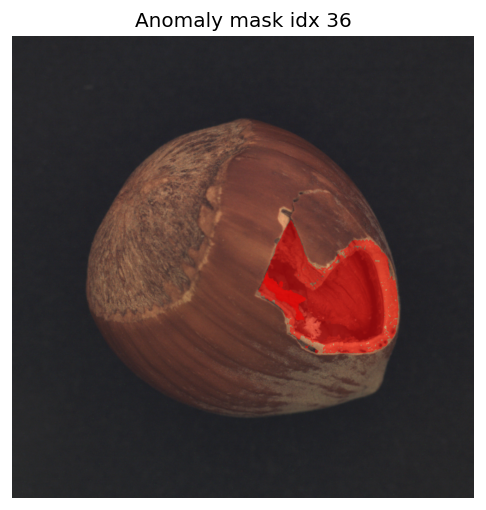

In [32]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

overlay_dir   = Path("/home/s2behappy4/data/gyuhyeong/code/overlays/hazelnut/crack")
overlay_paths = sorted(overlay_dir.glob("*_overlay.png"))     
img_path      = overlay_paths[best_idx]                       

img_rgba = Image.open(img_path).convert("RGBA")
w, h     = img_rgba.size
mask_np  = best_mask.cpu().numpy().astype(np.uint8) * 255  

mask_img = Image.fromarray(mask_np).resize((w, h), Image.NEAREST)

red_rgba = Image.new("RGBA", (w, h), (255, 0, 0, 128))        
overlay  = Image.new("RGBA", (w, h), (0, 0, 0, 0))
overlay.paste(red_rgba, mask=mask_img)

vis = Image.alpha_composite(img_rgba, overlay)

plt.figure(figsize=(5, 5))
plt.imshow(vis); plt.axis("off")
plt.title(f"Anomaly mask idx {best_idx}")
plt.show()


>>> anomaly mask index 선택 : 21  (score=0.0095)


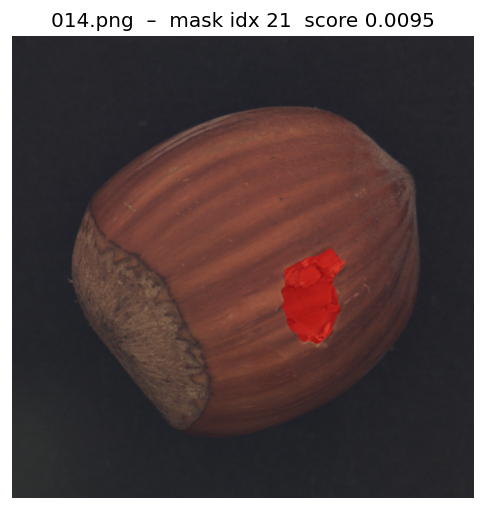

In [5]:
import torch
import torch.nn.functional as F

pairs_path = Path(
    "/home/s2behappy4/data/gyuhyeong/code/siglip_token/hazelnut/crack/01/014_pairs.pt"
)
pairs       = torch.load(pairs_path)
mask_tokens = torch.stack([p["mask_token"] for p in pairs])      
mask_tokens = mask_tokens.to(device, dtype=model.dtype).unsqueeze(0)    
mask_len    = mask_tokens.size(1)

with torch.no_grad():
    mask_embeds = model.multi_modal_projector(mask_tokens)       
mask_attn = torch.ones(1, mask_len, dtype=torch.long, device=device)

prompt = "Is there any anomaly in the image? (Yes or No).\n### Assistant:"
tok    = processor.tokenizer(prompt, return_tensors="pt").to(device)
text_embeds = model.get_input_embeddings()(tok.input_ids)         
text_mask   = tok.attention_mask                                  

sub_ids = processor.tokenizer(" anomaly", add_special_tokens=False).input_ids
seq     = tok.input_ids[0].tolist()
def find_sub(seq, sub):
    for i in range(len(seq)-len(sub)+1):
        if seq[i:i+len(sub)] == sub:
            return i
    return None
anomaly_idx = find_sub(seq, sub_ids)
assert anomaly_idx is not None, "'anomaly' 토큰을 찾지 못했습니다."

inputs_embeds  = torch.cat([mask_embeds, text_embeds], dim=1)
attention_mask = torch.cat([mask_attn,   text_mask],   dim=1)    

with torch.no_grad():
    out = model(
        inputs_embeds      = inputs_embeds,
        attention_mask     = attention_mask,
        output_attentions  = True,
        output_hidden_states = True,
        return_dict        = True
    )

alpha = 0.5
attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)  
score_A  = attn_avg[mask_len + anomaly_idx, :mask_len]                         

h_pre   = mask_embeds.squeeze(0)                
h_post  = out.hidden_states[-1].squeeze(0)[:mask_len]                           

anom_ids  = processor.tokenizer(" anomaly", add_special_tokens=False).input_ids
anom_ids  = torch.tensor(anom_ids, device=device)
anom_emb  = model.get_input_embeddings()(anom_ids)     
anom_emb  = anom_emb.mean(dim=0)                      

cos_pre  = F.cosine_similarity(h_pre , anom_emb.unsqueeze(0), dim=-1) 
cos_post = F.cosine_similarity(h_post, anom_emb.unsqueeze(0), dim=-1)  
score_B  = cos_post - cos_pre

final_score = alpha * score_A + (1 - alpha) * score_B
best_idx    = torch.argmax(final_score).item()
best_mask   = pairs[best_idx]["mask"]           

print(f"\n>>> anomaly mask index 선택 : {best_idx}  (score={final_score[best_idx]:.4f})")

best_mask = pairs[best_idx]["mask"]

import numpy as np, matplotlib.pyplot as plt
from PIL import Image

ROOT_IMG_DIR = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test")
DEFECT_TYPE  = "crack"         
IMG_PATH     = ROOT_IMG_DIR / DEFECT_TYPE / f"{pairs_path.stem.split('_')[0]}.png"

rgb = np.array(Image.open(IMG_PATH).convert("RGB"))       
H, W = rgb.shape[:2]

msk_np = best_mask.cpu().numpy().astype(np.uint8) * 255    
msk_im = Image.fromarray(msk_np).resize((W, H), Image.NEAREST)
msk_bool = np.array(msk_im, dtype=bool)

overlay = rgb.copy().astype(np.float32)
overlay[msk_bool] = 0.5 * overlay[msk_bool] + 0.5 * np.array([255, 0, 0])
overlay = overlay.astype(np.uint8)

plt.figure(figsize=(5,5), dpi=120)
plt.imshow(overlay); plt.axis("off")
plt.title(f"{IMG_PATH.name}  –  mask idx {best_idx}  score {final_score[best_idx]:.4f}")
plt.show()

# # Hazelnut P-AUROC

In [88]:
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PAIRS_DIR    = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token/hazelnut/crack/01")
ROOT_DS      = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut")
ALPHA        = 0.5

tok_img   = processor.tokenizer.additional_special_tokens[0]

def compute_scores(pairs):
    m_tok = torch.stack([p["mask_token"] for p in pairs]).unsqueeze(0)\
             .to(DEVICE, model.dtype)             
    with torch.no_grad():
        m_emb = model.multi_modal_projector(m_tok)            
    N = m_emb.size(1)
    prompt = (tok_img + " ") * N + "Where is the anomaly?"
    tok    = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
    t_emb  = model.get_input_embeddings()(tok.input_ids).to(model.dtype)  

    inp    = torch.cat([m_emb, t_emb], dim=1)                        
    att_m  = torch.cat([torch.ones(1, N, device=DEVICE, dtype=torch.long),
                        tok.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds     = inp,
                    attention_mask    = att_m,
                    output_attentions = True,
                    output_hidden_states = True,
                    return_dict       = True)
        
    attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
    an_idx   = inp.size(1) - 1
    sA       = attn_avg[an_idx, :N]

    h_pre    = m_emb.squeeze(0)
    h_post   = out.hidden_states[-1].squeeze(0)[:N]
    an_ids   = processor.tokenizer(" anomaly", add_special_tokens=False).input_ids
    an_emb   = model.get_input_embeddings()(torch.tensor(an_ids, device=DEVICE)).mean(0)
    sB       = (F.cosine_similarity(h_post, an_emb, -1)
              - F.cosine_similarity(h_pre , an_emb, -1))

    return ALPHA * sA + (1 - ALPHA) * sB  

def heatmap_from_masks(scores, masks, size):
    H, W = size
    hmap = np.zeros((H, W), dtype=np.float32)
    for s, m in zip(scores, masks):
        m_np = m.cpu().numpy().astype(bool)
        hmap[m_np] = np.maximum(hmap[m_np], float(s))
    return hmap.ravel()

per_image_auc = {}
all_pix_scores = []
all_pix_labels = []

for pt_path in sorted(PAIRS_DIR.glob("*_pairs.pt")):
    stem      = pt_path.stem.split("_")[0] 
    gt_path   = ROOT_DS / "ground_truth" / "crack" / f"{stem}_mask.png"

    pairs     = torch.load(pt_path)
    scores    = compute_scores(pairs).cpu()

    gt_im     = Image.open(gt_path).convert("L")
    H, W      = gt_im.size[1], gt_im.size[0]
    heatmap   = heatmap_from_masks(scores, [p["mask"] for p in pairs], (H, W))
    gt_bool   = (np.array(gt_im.resize((W, H), Image.NEAREST)) > 127).ravel().astype(np.uint8)

    p_auc     = roc_auc_score(gt_bool, heatmap)
    per_image_auc[stem] = p_auc

    all_pix_scores.extend(heatmap)
    all_pix_labels.extend(gt_bool)

print("┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓")
print("┃  crack 각 이미지 P-AUROC  ┃")
print("┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛")
for k, v in per_image_auc.items():
    print(f"{k}: {v:.4f}")

overall_p = roc_auc_score(all_pix_labels, all_pix_scores)
print(f"\ncrack 전체 P-AUROC : {overall_p:.4f}")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  crack 각 이미지 P-AUROC  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
000: 0.8838
001: 0.9775
002: 0.7732
003: 0.8018
004: 0.5095
005: 0.4409
006: 0.5000
007: 0.9710
008: 0.5225
009: 0.5379
010: 0.4766
011: 0.9195
012: 0.8422
013: 0.5000
014: 0.9850
015: 0.8197
016: 0.3283
017: 0.8988

crack 전체 P-AUROC : 0.5424


In [89]:
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PAIRS_DIR    = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token/hazelnut/cut/01")
ROOT_DS      = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut")
ALPHA        = 0.5

tok_img   = processor.tokenizer.additional_special_tokens[0]  

def compute_scores(pairs):
    m_tok = torch.stack([p["mask_token"] for p in pairs]).unsqueeze(0)\
             .to(DEVICE, model.dtype)             
    with torch.no_grad():
        m_emb = model.multi_modal_projector(m_tok)         
    N = m_emb.size(1)
    prompt = (tok_img + " ") * N + "Is there any anomaly in the image?"
    tok    = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
    t_emb  = model.get_input_embeddings()(tok.input_ids).to(model.dtype)  

    inp    = torch.cat([m_emb, t_emb], dim=1)                        
    att_m  = torch.cat([torch.ones(1, N, device=DEVICE, dtype=torch.long),
                        tok.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds     = inp,
                    attention_mask    = att_m,
                    output_attentions = True,
                    output_hidden_states = True,
                    return_dict       = True)

    attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
    an_idx   = inp.size(1) - 1
    sA       = attn_avg[an_idx, :N]

    h_pre    = m_emb.squeeze(0)
    h_post   = out.hidden_states[-1].squeeze(0)[:N]
    an_ids   = processor.tokenizer(" anomaly", add_special_tokens=False).input_ids
    an_emb   = model.get_input_embeddings()(torch.tensor(an_ids, device=DEVICE)).mean(0)
    sB       = (F.cosine_similarity(h_post, an_emb, -1)
              - F.cosine_similarity(h_pre , an_emb, -1))

    return ALPHA * sA + (1 - ALPHA) * sB  

def heatmap_from_masks(scores, masks, size):
    H, W = size
    hmap = np.zeros((H, W), dtype=np.float32)
    for s, m in zip(scores, masks):
        m_np = m.cpu().numpy().astype(bool)
        hmap[m_np] = np.maximum(hmap[m_np], float(s))
    return hmap.ravel()

per_image_auc = {}
all_pix_scores = []
all_pix_labels = []

for pt_path in sorted(PAIRS_DIR.glob("*_pairs.pt")):
    stem      = pt_path.stem.split("_")[0]  
    gt_path   = ROOT_DS / "ground_truth" / "cut" / f"{stem}_mask.png"

    pairs     = torch.load(pt_path)
    scores    = compute_scores(pairs).cpu()

    gt_im     = Image.open(gt_path).convert("L")
    H, W      = gt_im.size[1], gt_im.size[0]
    heatmap   = heatmap_from_masks(scores, [p["mask"] for p in pairs], (H, W))
    gt_bool   = (np.array(gt_im.resize((W, H), Image.NEAREST)) > 127).ravel().astype(np.uint8)

    p_auc     = roc_auc_score(gt_bool, heatmap)
    per_image_auc[stem] = p_auc

    all_pix_scores.extend(heatmap)
    all_pix_labels.extend(gt_bool)

print("┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓")
print("┃  cut 각 이미지 P-AUROC  ┃")
print("┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛")
for k, v in per_image_auc.items():
    print(f"{k}: {v:.4f}")

overall_p = roc_auc_score(all_pix_labels, all_pix_scores)
print(f"\ncut 전체 P-AUROC : {overall_p:.4f}")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  cut 각 이미지 P-AUROC  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
000: 0.1790
001: 0.5000
002: 0.7872
003: 0.2002
004: 0.5000
005: 0.0998
006: 0.1965
007: 0.8109
008: 0.7165
009: 0.8546
010: 0.7944
011: 0.6032
012: 0.7667
013: 0.1447
014: 0.5000
015: 0.8173
016: 0.7989

cut 전체 P-AUROC : 0.5300


In [4]:
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PAIRS_DIR    = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token/hazelnut/hole/01")
ROOT_DS      = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut")
ALPHA        = 0.5

tok_img   = processor.tokenizer.additional_special_tokens[0]  

def compute_scores(pairs):
    m_tok = torch.stack([p["mask_token"] for p in pairs]).unsqueeze(0)\
             .to(DEVICE, model.dtype)             
    with torch.no_grad():
        m_emb = model.multi_modal_projector(m_tok)           
    N = m_emb.size(1)
    prompt = (tok_img + " ") * N + "Is there any anomaly in the image?"
    tok    = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
    t_emb  = model.get_input_embeddings()(tok.input_ids).to(model.dtype)  

    inp    = torch.cat([m_emb, t_emb], dim=1)                         
    att_m  = torch.cat([torch.ones(1, N, device=DEVICE, dtype=torch.long),
                        tok.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds     = inp,
                    attention_mask    = att_m,
                    output_attentions = True,
                    output_hidden_states = True,
                    return_dict       = True)

    attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
    an_idx   = inp.size(1) - 1
    sA       = attn_avg[an_idx, :N]

    h_pre    = m_emb.squeeze(0)
    h_post   = out.hidden_states[-1].squeeze(0)[:N]
    an_ids   = processor.tokenizer(" anomaly", add_special_tokens=False).input_ids
    an_emb   = model.get_input_embeddings()(torch.tensor(an_ids, device=DEVICE)).mean(0)
    sB       = (F.cosine_similarity(h_post, an_emb, -1)
              - F.cosine_similarity(h_pre , an_emb, -1))

    return ALPHA * sA + (1 - ALPHA) * sB  

def heatmap_from_masks(scores, masks, size):
    H, W = size
    hmap = np.zeros((H, W), dtype=np.float32)
    for s, m in zip(scores, masks):
        m_np = m.cpu().numpy().astype(bool)
        hmap[m_np] = np.maximum(hmap[m_np], float(s))
    return hmap.ravel()

per_image_auc = {}
all_pix_scores = []
all_pix_labels = []

for pt_path in sorted(PAIRS_DIR.glob("*_pairs.pt")):
    stem      = pt_path.stem.split("_")[0]  
    gt_path   = ROOT_DS / "ground_truth" / "hole" / f"{stem}_mask.png"

    pairs     = torch.load(pt_path)
    scores    = compute_scores(pairs).cpu()

    gt_im     = Image.open(gt_path).convert("L")
    H, W      = gt_im.size[1], gt_im.size[0]
    heatmap   = heatmap_from_masks(scores, [p["mask"] for p in pairs], (H, W))
    gt_bool   = (np.array(gt_im.resize((W, H), Image.NEAREST)) > 127).ravel().astype(np.uint8)

    p_auc     = roc_auc_score(gt_bool, heatmap)
    per_image_auc[stem] = p_auc

    all_pix_scores.extend(heatmap)
    all_pix_labels.extend(gt_bool)

print("┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓")
print("┃  hole 각 이미지 P-AUROC  ┃")
print("┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛")
for k, v in per_image_auc.items():
    print(f"{k}: {v:.4f}")

overall_p = roc_auc_score(all_pix_labels, all_pix_scores)
print(f"\nhole 전체 P-AUROC : {overall_p:.4f}")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  hole 각 이미지 P-AUROC  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
000: 0.7418
001: 0.8595
002: 0.8158
003: 0.7135
004: 0.8354
005: 0.8720
006: 0.9294
007: 0.9208
008: 0.9296
009: 0.5794
010: 0.9398
011: 0.5000
012: 0.8243
013: 0.8545
014: 0.6955
015: 0.8967
016: 0.8448
017: 0.9081

hole 전체 P-AUROC : 0.7322


In [3]:
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PAIRS_DIR    = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token/hazelnut/print/01")
ROOT_DS      = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut")
ALPHA        = 0.5

tok_img   = processor.tokenizer.additional_special_tokens[0] 

def compute_scores(pairs):
    m_tok = torch.stack([p["mask_token"] for p in pairs]).unsqueeze(0)\
             .to(DEVICE, model.dtype)          
    with torch.no_grad():
        m_emb = model.multi_modal_projector(m_tok)          
    N = m_emb.size(1)
    prompt = (tok_img + " ") * N + "Is there any anomaly in the image?"
    tok    = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
    t_emb  = model.get_input_embeddings()(tok.input_ids).to(model.dtype) 

    inp    = torch.cat([m_emb, t_emb], dim=1)                        
    att_m  = torch.cat([torch.ones(1, N, device=DEVICE, dtype=torch.long),
                        tok.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds     = inp,
                    attention_mask    = att_m,
                    output_attentions = True,
                    output_hidden_states = True,
                    return_dict       = True)

    attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
    an_idx   = inp.size(1) - 1
    sA       = attn_avg[an_idx, :N]

    h_pre    = m_emb.squeeze(0)
    h_post   = out.hidden_states[-1].squeeze(0)[:N]
    an_ids   = processor.tokenizer(" anomaly", add_special_tokens=False).input_ids
    an_emb   = model.get_input_embeddings()(torch.tensor(an_ids, device=DEVICE)).mean(0)
    sB       = (F.cosine_similarity(h_post, an_emb, -1)
              - F.cosine_similarity(h_pre , an_emb, -1))

    return ALPHA * sA + (1 - ALPHA) * sB  

def heatmap_from_masks(scores, masks, size):
    H, W = size
    hmap = np.zeros((H, W), dtype=np.float32)
    for s, m in zip(scores, masks):
        m_np = m.cpu().numpy().astype(bool)
        hmap[m_np] = np.maximum(hmap[m_np], float(s))
    return hmap.ravel()

per_image_auc = {}
all_pix_scores = []
all_pix_labels = []

for pt_path in sorted(PAIRS_DIR.glob("*_pairs.pt")):
    stem      = pt_path.stem.split("_")[0]  
    gt_path   = ROOT_DS / "ground_truth" / "print" / f"{stem}_mask.png"

    pairs     = torch.load(pt_path)
    scores    = compute_scores(pairs).cpu()

    gt_im     = Image.open(gt_path).convert("L")
    H, W      = gt_im.size[1], gt_im.size[0]
    heatmap   = heatmap_from_masks(scores, [p["mask"] for p in pairs], (H, W))
    gt_bool   = (np.array(gt_im.resize((W, H), Image.NEAREST)) > 127).ravel().astype(np.uint8)

    p_auc     = roc_auc_score(gt_bool, heatmap)
    per_image_auc[stem] = p_auc

    all_pix_scores.extend(heatmap)
    all_pix_labels.extend(gt_bool)

print("┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓")
print("┃  print 각 이미지 P-AUROC  ┃")
print("┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛")
for k, v in per_image_auc.items():
    print(f"{k}: {v:.4f}")

overall_p = roc_auc_score(all_pix_labels, all_pix_scores)
print(f"\nprint 전체 P-AUROC : {overall_p:.4f}")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  print 각 이미지 P-AUROC  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
000: 0.7739
001: 0.8063
002: 0.8729
003: 0.5794
004: 0.3802
005: 0.1682
006: 0.6334
007: 0.8482
008: 0.7988
009: 0.9499
010: 0.9561
011: 0.9520
012: 0.8847
013: 0.9502
014: 0.2093
015: 0.2306
016: 0.1598

print 전체 P-AUROC : 0.5921


# # Anomaly Score Distribution

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  print 각 이미지 P-AUROC  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
000: 0.7739
001: 0.8063
002: 0.8729
003: 0.5794
004: 0.3802
005: 0.1682
006: 0.6334
007: 0.8482
008: 0.7988
009: 0.9499
010: 0.9561
011: 0.9520
012: 0.8847
013: 0.9502
014: 0.2093
015: 0.2306
016: 0.1598

print 전체 P-AUROC : 0.5921


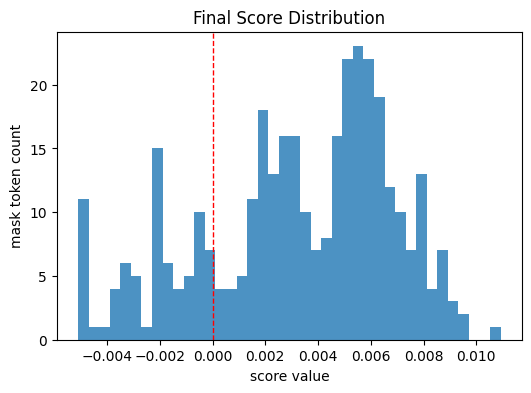

number of mask 349


In [24]:
import torch, torch.nn.functional as F, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score

DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
PAIRS_DIR   = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token/hazelnut/print/01")
ROOT_DS     = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut")
ALPHA       = 0.5
tok_img     = processor.tokenizer.additional_special_tokens[0]  

def final_scores_raw(pairs):
    m_tok = torch.stack([p["mask_token"] for p in pairs]).unsqueeze(0)\
             .to(DEVICE, model.dtype)                             
    with torch.no_grad():
        m_emb = model.multi_modal_projector(m_tok)              
    N = m_emb.size(1)
    prompt = (tok_img + " ") * N + "Is there any anomaly in the image?"
    tok    = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
    t_emb  = model.get_input_embeddings()(tok.input_ids).to(model.dtype)

    inp   = torch.cat([m_emb, t_emb], dim=1)
    att_m = torch.cat([torch.ones(1, N, device=DEVICE, dtype=torch.long),
                       tok.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds=inp, attention_mask=att_m,
                    output_attentions=True, output_hidden_states=True,
                    return_dict=True)

    attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
    sA = attn_avg[inp.size(1)-1, :N]

    h_pre  = m_emb.squeeze(0)
    h_post = out.hidden_states[-1].squeeze(0)[:N]
    v_anom = model.get_input_embeddings()(
                torch.tensor(processor.tokenizer(" anomaly",
                          add_special_tokens=False).input_ids, device=DEVICE)
             ).mean(0)
    sB = F.cosine_similarity(h_post, v_anom, -1) \
       - F.cosine_similarity(h_pre , v_anom, -1)
    return (ALPHA * sA + (1 - ALPHA) * sB).detach().float().cpu().numpy()

def heatmap_from_masks(scores, masks, size):
    H, W = size
    hmap = np.zeros((H, W), dtype=np.float32)
    for s, m in zip(scores, masks):
        m_np = m.cpu().numpy().astype(bool)
        hmap[m_np] = np.maximum(hmap[m_np], float(s))
    return hmap.ravel()

per_image_auc, all_pix_scores, all_pix_labels = {}, [], []
all_mask_scores = []      

for pt_path in sorted(PAIRS_DIR.glob("*_pairs.pt")):
    stem    = pt_path.stem.split("_")[0]
    gt_path = ROOT_DS / "ground_truth" / "print" / f"{stem}_mask.png"

    pairs   = torch.load(pt_path)
    scores  = final_scores_raw(pairs)
    all_mask_scores.extend(scores)         

    gt_im   = Image.open(gt_path).convert("L")
    H, W    = gt_im.size[1], gt_im.size[0]
    heatmap = heatmap_from_masks(scores, [p["mask"] for p in pairs], (H, W))
    gt_bool = (np.array(gt_im.resize((W, H), Image.NEAREST)) > 127).ravel().astype(np.uint8)

    p_auc   = roc_auc_score(gt_bool, heatmap)
    per_image_auc[stem] = p_auc
    all_pix_scores.extend(heatmap)
    all_pix_labels.extend(gt_bool)

print("┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓")
print("┃  print 각 이미지 P-AUROC  ┃")
print("┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛")
for k, v in per_image_auc.items():
    print(f"{k}: {v:.4f}")

overall_p = roc_auc_score(all_pix_labels, all_pix_scores)
print(f"\nprint 전체 P-AUROC : {overall_p:.4f}")

plt.figure(figsize=(6,4))
plt.hist(all_mask_scores, bins=40, alpha=0.8)
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.title("Final Score Distribution")
plt.xlabel("score value"); plt.ylabel("mask token count")
plt.show()
print("number of mask", len(all_mask_scores))

# # Global Shift 적용 후 Distribution 변화

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  print 각 이미지 P-AUROC  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
000: 0.7739
001: 0.8063
002: 0.8729
003: 0.5794
004: 0.3803
005: 0.1682
006: 0.9040
007: 0.8482
008: 0.8613
009: 0.9507
010: 0.9561
011: 0.9520
012: 0.8900
013: 0.9520
014: 0.2093
015: 0.2306
016: 0.1598

print 전체 P-AUROC : 0.6692


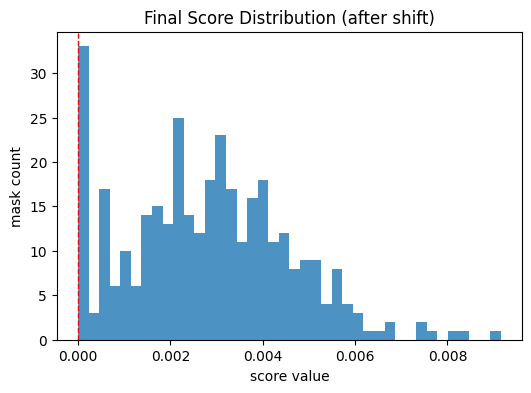

In [22]:
import torch, torch.nn.functional as F, numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PAIRS_DIR    = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token/hazelnut/print/01")
ROOT_DS      = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut")
ALPHA        = 0.5

tok_img = processor.tokenizer.additional_special_tokens[0]  

def compute_scores(pairs):
    m_tok = torch.stack([p["mask_token"] for p in pairs]).unsqueeze(0)\
             .to(DEVICE, model.dtype)                                 

    with torch.no_grad():
        m_emb = model.multi_modal_projector(m_tok)                    
    N = m_emb.size(1)
    prompt = (tok_img + " ") * N + "Is there any anomaly in the image?"
    tok    = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
    t_emb  = model.get_input_embeddings()(tok.input_ids).to(model.dtype)

    inp   = torch.cat([m_emb, t_emb], dim=1)                         
    att_m = torch.cat([torch.ones(1, N, device=DEVICE, dtype=torch.long),
                       tok.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds=inp,
                    attention_mask=att_m,
                    output_attentions=True,
                    output_hidden_states=True,
                    return_dict=True)

    attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
    sA = attn_avg[inp.size(1)-1, :N]                                  

    h_pre  = m_emb.squeeze(0)
    h_post = out.hidden_states[-1].squeeze(0)[:N]
    v_anom = model.get_input_embeddings()(
                torch.tensor(processor.tokenizer(
                    " anomaly", add_special_tokens=False).input_ids,
                    device=DEVICE)
              ).mean(0)
    sB = F.cosine_similarity(h_post, v_anom, -1) - F.cosine_similarity(h_pre, v_anom, -1)

    raw = ALPHA * sA + (1 - ALPHA) * sB                              
    return raw - raw.min()

def heatmap_from_masks(scores, masks, size):
    H, W = size
    hmap = np.zeros((H, W), dtype=np.float32)
    for s, m in zip(scores, masks):
        m_np = m.cpu().numpy().astype(bool)
        hmap[m_np] = np.maximum(hmap[m_np], float(s))
    return hmap.ravel()

per_image_auc, all_pix_scores, all_pix_labels = {}, [], []
all_mask_scores_shifted = []          

for pt_path in sorted(PAIRS_DIR.glob("*_pairs.pt")):
    stem    = pt_path.stem.split("_")[0]                                
    gt_path = ROOT_DS / "ground_truth" / "print" / f"{stem}_mask.png"

    pairs   = torch.load(pt_path)
    scores  = compute_scores(pairs).detach().float().cpu().numpy()     
    all_mask_scores_shifted.extend(scores)          

    gt_im   = Image.open(gt_path).convert("L")
    H, W    = gt_im.size[1], gt_im.size[0]
    heatmap = heatmap_from_masks(scores, [p["mask"] for p in pairs], (H, W))
    gt_bool = (np.array(gt_im.resize((W, H), Image.NEAREST)) > 127).ravel().astype(np.uint8)

    p_auc   = roc_auc_score(gt_bool, heatmap)
    per_image_auc[stem] = p_auc

    all_pix_scores.extend(heatmap)
    all_pix_labels.extend(gt_bool)

print("┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓")
print("┃  print 각 이미지 P-AUROC  ┃")
print("┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛")
for k, v in per_image_auc.items():
    print(f"{k}: {v:.4f}")

overall_p = roc_auc_score(all_pix_labels, all_pix_scores)
print(f"\nprint 전체 P-AUROC : {overall_p:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(all_mask_scores_shifted, bins=40, alpha=0.8, color="#1f77b4")
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.title("Final Score Distribution (after shift)")
plt.xlabel("score value"); plt.ylabel("mask count")
plt.show()

# # Global Shift 적용 후 P-AUROC 결과

In [15]:
import torch, torch.nn.functional as F, numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PAIRS_DIR    = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token/hazelnut/crack/01")
ROOT_DS      = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut")
ALPHA        = 0.5

tok_img = processor.tokenizer.additional_special_tokens[0] 

def compute_scores(pairs):
    m_tok = torch.stack([p["mask_token"] for p in pairs]).unsqueeze(0)\
             .to(DEVICE, model.dtype)                                

    with torch.no_grad():
        m_emb = model.multi_modal_projector(m_tok)                
    N = m_emb.size(1)
    prompt = (tok_img + " ") * N + "Is there any anomaly in the image?"
    tok    = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
    t_emb  = model.get_input_embeddings()(tok.input_ids).to(model.dtype)

    inp   = torch.cat([m_emb, t_emb], dim=1)                          
    att_m = torch.cat([torch.ones(1, N, device=DEVICE, dtype=torch.long),
                       tok.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds=inp,
                    attention_mask=att_m,
                    output_attentions=True,
                    output_hidden_states=True,
                    return_dict=True)

    attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
    sA = attn_avg[inp.size(1)-1, :N]                                 

    h_pre  = m_emb.squeeze(0)
    h_post = out.hidden_states[-1].squeeze(0)[:N]
    v_anom = model.get_input_embeddings()(
                torch.tensor(processor.tokenizer(
                    " anomaly", add_special_tokens=False).input_ids,
                    device=DEVICE)
              ).mean(0)
    sB = F.cosine_similarity(h_post, v_anom, -1) - F.cosine_similarity(h_pre, v_anom, -1)

    raw = ALPHA * sA + (1 - ALPHA) * sB                              
    return raw - raw.min()

def heatmap_from_masks(scores, masks, size):
    H, W = size
    hmap = np.zeros((H, W), dtype=np.float32)
    for s, m in zip(scores, masks):
        m_np = m.cpu().numpy().astype(bool)
        hmap[m_np] = np.maximum(hmap[m_np], float(s))
    return hmap.ravel()

per_image_auc, all_pix_scores, all_pix_labels = {}, [], []

for pt_path in sorted(PAIRS_DIR.glob("*_pairs.pt")):
    stem    = pt_path.stem.split("_")[0]                                  
    gt_path = ROOT_DS / "ground_truth" / "crack" / f"{stem}_mask.png"

    pairs   = torch.load(pt_path)
    scores  = compute_scores(pairs).cpu()                      

    gt_im   = Image.open(gt_path).convert("L")
    H, W    = gt_im.size[1], gt_im.size[0]
    heatmap = heatmap_from_masks(scores, [p["mask"] for p in pairs], (H, W))
    gt_bool = (np.array(gt_im.resize((W, H), Image.NEAREST)) > 127).ravel().astype(np.uint8)

    p_auc   = roc_auc_score(gt_bool, heatmap)
    per_image_auc[stem] = p_auc

    all_pix_scores.extend(heatmap)
    all_pix_labels.extend(gt_bool)

print("┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓")
print("┃  crack 각 이미지 P-AUROC  ┃")
print("┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛")
for k, v in per_image_auc.items():
    print(f"{k}: {v:.4f}")

overall_p = roc_auc_score(all_pix_labels, all_pix_scores)
print(f"\ncrack 전체 P-AUROC : {overall_p:.4f}")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  crack 각 이미지 P-AUROC  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
000: 0.8838
001: 0.9769
002: 0.8206
003: 0.8018
004: 0.6705
005: 0.5049
006: 0.9203
007: 0.9710
008: 0.8582
009: 0.9597
010: 0.8845
011: 0.9195
012: 0.8422
013: 0.9302
014: 0.9850
015: 0.9641
016: 0.3283
017: 0.8502

crack 전체 P-AUROC : 0.7382


In [10]:
import torch, torch.nn.functional as F, numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PAIRS_DIR    = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token/hazelnut/cut/01")
ROOT_DS      = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut")
ALPHA        = 0.5

tok_img = processor.tokenizer.additional_special_tokens[0] 

def compute_scores(pairs):
    m_tok = torch.stack([p["mask_token"] for p in pairs]).unsqueeze(0)\
             .to(DEVICE, model.dtype)                                 

    with torch.no_grad():
        m_emb = model.multi_modal_projector(m_tok)                    
    N = m_emb.size(1)
    prompt = (tok_img + " ") * N + "Is there any anomaly in the image?"
    tok    = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
    t_emb  = model.get_input_embeddings()(tok.input_ids).to(model.dtype)

    inp   = torch.cat([m_emb, t_emb], dim=1)                        
    att_m = torch.cat([torch.ones(1, N, device=DEVICE, dtype=torch.long),
                       tok.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds=inp,
                    attention_mask=att_m,
                    output_attentions=True,
                    output_hidden_states=True,
                    return_dict=True)

    attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
    sA = attn_avg[inp.size(1)-1, :N]                                  

    h_pre  = m_emb.squeeze(0)
    h_post = out.hidden_states[-1].squeeze(0)[:N]
    v_anom = model.get_input_embeddings()(
                torch.tensor(processor.tokenizer(
                    " anomaly", add_special_tokens=False).input_ids,
                    device=DEVICE)
              ).mean(0)
    sB = F.cosine_similarity(h_post, v_anom, -1) - F.cosine_similarity(h_pre, v_anom, -1)

    raw = ALPHA * sA + (1 - ALPHA) * sB                               
    return raw - raw.min()

def heatmap_from_masks(scores, masks, size):
    H, W = size
    hmap = np.zeros((H, W), dtype=np.float32)
    for s, m in zip(scores, masks):
        m_np = m.cpu().numpy().astype(bool)
        hmap[m_np] = np.maximum(hmap[m_np], float(s))
    return hmap.ravel()

per_image_auc, all_pix_scores, all_pix_labels = {}, [], []

for pt_path in sorted(PAIRS_DIR.glob("*_pairs.pt")):
    stem    = pt_path.stem.split("_")[0]                                
    gt_path = ROOT_DS / "ground_truth" / "cut" / f"{stem}_mask.png"

    pairs   = torch.load(pt_path)
    scores  = compute_scores(pairs).cpu()                      

    gt_im   = Image.open(gt_path).convert("L")
    H, W    = gt_im.size[1], gt_im.size[0]
    heatmap = heatmap_from_masks(scores, [p["mask"] for p in pairs], (H, W))
    gt_bool = (np.array(gt_im.resize((W, H), Image.NEAREST)) > 127).ravel().astype(np.uint8)

    p_auc   = roc_auc_score(gt_bool, heatmap)
    per_image_auc[stem] = p_auc

    all_pix_scores.extend(heatmap)
    all_pix_labels.extend(gt_bool)

print("┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓")
print("┃  cut 각 이미지 P-AUROC  ┃")
print("┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛")
for k, v in per_image_auc.items():
    print(f"{k}: {v:.4f}")

overall_p = roc_auc_score(all_pix_labels, all_pix_scores)
print(f"\ncut 전체 P-AUROC : {overall_p:.4f}")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  cut 각 이미지 P-AUROC  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
000: 0.1787
001: 0.8864
002: 0.7872
003: 0.2002
004: 0.2823
005: 0.0998
006: 0.1966
007: 0.8141
008: 0.7667
009: 0.8546
010: 0.7944
011: 0.6032
012: 0.7667
013: 0.1447
014: 0.2450
015: 0.8173
016: 0.7988

cut 전체 P-AUROC : 0.5499


In [9]:
import torch, torch.nn.functional as F, numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PAIRS_DIR    = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token/hazelnut/hole/01")
ROOT_DS      = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut")
ALPHA        = 0.5

tok_img = processor.tokenizer.additional_special_tokens[0] 

def compute_scores(pairs):
    m_tok = torch.stack([p["mask_token"] for p in pairs]).unsqueeze(0)\
             .to(DEVICE, model.dtype)                                

    with torch.no_grad():
        m_emb = model.multi_modal_projector(m_tok)                   
    N = m_emb.size(1)
    prompt = (tok_img + " ") * N + "Is there any anomaly in the image?"
    tok    = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
    t_emb  = model.get_input_embeddings()(tok.input_ids).to(model.dtype)

    inp   = torch.cat([m_emb, t_emb], dim=1)                         
    att_m = torch.cat([torch.ones(1, N, device=DEVICE, dtype=torch.long),
                       tok.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds=inp,
                    attention_mask=att_m,
                    output_attentions=True,
                    output_hidden_states=True,
                    return_dict=True)

    attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
    sA = attn_avg[inp.size(1)-1, :N]                                

    h_pre  = m_emb.squeeze(0)
    h_post = out.hidden_states[-1].squeeze(0)[:N]
    v_anom = model.get_input_embeddings()(
                torch.tensor(processor.tokenizer(
                    " anomaly", add_special_tokens=False).input_ids,
                    device=DEVICE)
              ).mean(0)
    sB = F.cosine_similarity(h_post, v_anom, -1) - F.cosine_similarity(h_pre, v_anom, -1)

    raw = ALPHA * sA + (1 - ALPHA) * sB                           
    return raw - raw.min()

def heatmap_from_masks(scores, masks, size):
    H, W = size
    hmap = np.zeros((H, W), dtype=np.float32)
    for s, m in zip(scores, masks):
        m_np = m.cpu().numpy().astype(bool)
        hmap[m_np] = np.maximum(hmap[m_np], float(s))
    return hmap.ravel()

per_image_auc, all_pix_scores, all_pix_labels = {}, [], []

for pt_path in sorted(PAIRS_DIR.glob("*_pairs.pt")):
    stem    = pt_path.stem.split("_")[0]                                  
    gt_path = ROOT_DS / "ground_truth" / "hole" / f"{stem}_mask.png"

    pairs   = torch.load(pt_path)
    scores  = compute_scores(pairs).cpu()                       

    gt_im   = Image.open(gt_path).convert("L")
    H, W    = gt_im.size[1], gt_im.size[0]
    heatmap = heatmap_from_masks(scores, [p["mask"] for p in pairs], (H, W))
    gt_bool = (np.array(gt_im.resize((W, H), Image.NEAREST)) > 127).ravel().astype(np.uint8)

    p_auc   = roc_auc_score(gt_bool, heatmap)
    per_image_auc[stem] = p_auc

    all_pix_scores.extend(heatmap)
    all_pix_labels.extend(gt_bool)

print("┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓")
print("┃  hole 각 이미지 P-AUROC  ┃")
print("┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛")
for k, v in per_image_auc.items():
    print(f"{k}: {v:.4f}")

overall_p = roc_auc_score(all_pix_labels, all_pix_scores)
print(f"\nhole 전체 P-AUROC : {overall_p:.4f}")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  hole 각 이미지 P-AUROC  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
000: 0.7205
001: 0.8595
002: 0.8158
003: 0.9076
004: 0.8354
005: 0.8720
006: 0.9446
007: 0.9190
008: 0.8631
009: 0.9599
010: 0.9398
011: 0.9332
012: 0.8160
013: 0.8545
014: 0.8664
015: 0.8335
016: 0.8446
017: 0.9081

hole 전체 P-AUROC : 0.8717


In [7]:
import torch, torch.nn.functional as F, numpy as np
from pathlib import Path
from PIL import Image
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
PAIRS_DIR    = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token/hazelnut/print/01")
ROOT_DS      = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut")
ALPHA        = 0.5

tok_img = processor.tokenizer.additional_special_tokens[0]

def compute_scores(pairs):
    m_tok = torch.stack([p["mask_token"] for p in pairs]).unsqueeze(0)\
             .to(DEVICE, model.dtype)                               

    with torch.no_grad():
        m_emb = model.multi_modal_projector(m_tok)               
    N = m_emb.size(1)
    prompt = (tok_img + " ") * N + "Is there any anomaly in the image?"
    tok    = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
    t_emb  = model.get_input_embeddings()(tok.input_ids).to(model.dtype)

    inp   = torch.cat([m_emb, t_emb], dim=1)                       
    att_m = torch.cat([torch.ones(1, N, device=DEVICE, dtype=torch.long),
                       tok.attention_mask], dim=1)

    with torch.no_grad():
        out = model(inputs_embeds=inp,
                    attention_mask=att_m,
                    output_attentions=True,
                    output_hidden_states=True,
                    return_dict=True)

    attn_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
    sA = attn_avg[inp.size(1)-1, :N]                                 

    h_pre  = m_emb.squeeze(0)
    h_post = out.hidden_states[-1].squeeze(0)[:N]
    v_anom = model.get_input_embeddings()(
                torch.tensor(processor.tokenizer(
                    " anomaly", add_special_tokens=False).input_ids,
                    device=DEVICE)
              ).mean(0)
    sB = F.cosine_similarity(h_post, v_anom, -1) - F.cosine_similarity(h_pre, v_anom, -1)

    raw = ALPHA * sA + (1 - ALPHA) * sB                             
    return raw - raw.min()

def heatmap_from_masks(scores, masks, size):
    H, W = size
    hmap = np.zeros((H, W), dtype=np.float32)
    for s, m in zip(scores, masks):
        m_np = m.cpu().numpy().astype(bool)
        hmap[m_np] = np.maximum(hmap[m_np], float(s))
    return hmap.ravel()

per_image_auc, all_pix_scores, all_pix_labels = {}, [], []

for pt_path in sorted(PAIRS_DIR.glob("*_pairs.pt")):
    stem    = pt_path.stem.split("_")[0]                               
    gt_path = ROOT_DS / "ground_truth" / "print" / f"{stem}_mask.png"

    pairs   = torch.load(pt_path)
    scores  = compute_scores(pairs).cpu()                      

    gt_im   = Image.open(gt_path).convert("L")
    H, W    = gt_im.size[1], gt_im.size[0]
    heatmap = heatmap_from_masks(scores, [p["mask"] for p in pairs], (H, W))
    gt_bool = (np.array(gt_im.resize((W, H), Image.NEAREST)) > 127).ravel().astype(np.uint8)

    p_auc   = roc_auc_score(gt_bool, heatmap)
    per_image_auc[stem] = p_auc

    all_pix_scores.extend(heatmap)
    all_pix_labels.extend(gt_bool)

print("┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓")
print("┃  print 각 이미지 P-AUROC  ┃")
print("┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛")
for k, v in per_image_auc.items():
    print(f"{k}: {v:.4f}")

overall_p = roc_auc_score(all_pix_labels, all_pix_scores)
print(f"\nprint 전체 P-AUROC : {overall_p:.4f}")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  print 각 이미지 P-AUROC  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
000: 0.7739
001: 0.8063
002: 0.8729
003: 0.5794
004: 0.3803
005: 0.1682
006: 0.9040
007: 0.8482
008: 0.8613
009: 0.9507
010: 0.9561
011: 0.9520
012: 0.8900
013: 0.9520
014: 0.2093
015: 0.2306
016: 0.1598

print 전체 P-AUROC : 0.6692
